In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"]='1'


%pip install comet_ml
from comet_ml import Experiment

     |████████████████████████████████| 194kB 2.8MB/s 
     |████████████████████████████████| 204kB 47.8MB/s 
     |████████████████████████████████| 409kB 42.4MB/s 
  Created wheel for configobj: filename=configobj-5.0.6-cp36-none-any.whl size=34546 sha256=a5a5e27df30d1de2011768565325920108c8840b9554f015c39ea7c544480d63
  Stored in directory: /root/.cache/pip/wheels/f1/e4/16/4981ca97c2d65106b49861e0b35e2660695be7219a2d351ee0
Successfully built configobj


### This notebook:
###### 1. Super-quick intro into BaBar DIRC subdetector
###### 2. You create a WGAP-GP GAN

###### BaBar DIRC:
![image](https://www.slac.stanford.edu/BFROOT/www/Detector/DIRC/Gifs/NewDirc.gif)

Detection of Internally Reflected Cherenkov light - a particle identification detector in other words.
We will only generate high-level observables (particle delta log-likelihoods (DLL)) that are obtained after the reconstruction.

We want the generation to be conditional on full kinematics of event: energy, pseudorapidity and the distance between the particle track and DIRC bar side of signal particle. For the data-driven GAN this is just 11-D tabular data.

Data was generated with FastDIRC modified to simulate two particle-events.

Эта тетрадка сделана так, чтобы быть и семинарской тетрадкой и домашкой.

### Задача
A couple of years ago this would have been a paper in a good journal, now should be doable in 20-60 minutes*:
* after Denis Derkach formulated the problem and ёж did all the dirty work of getting training data

Задача в общем виде выглядит как:

Create a conditional **GAN NAME** to generate Y given X


### Задачи:

1. JS-GAN, 1.5 балла
1. [Least Squares GAN](https://arxiv.org/abs/1611.04076), 1 балл
2. WGAN, 1.5 балла
3. WGAN-GP, 2 балла
4. VAE, 1.5 балла
5. Написать метрику с классфикатором, 2 балла
6. Написать обьяснения, 0.5 балла
7. Напишите любой достаточно сложный ган (например [отсюда](https://towardsdatascience.com/gan-objective-functions-gans-and-their-variations-ad77340bce3c)), получите до 5 бонусных баллов

# Данные

Сюда можно не смотреть

In [0]:
import requests
import re

URL_RE = r"http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\(\), ]|(?:%[0-9a-fA-F][0-9a-fA-F]))+"
url_scrabber = re.compile(r'\s*<input type="hidden" name="downloadURL" '
                          'value="(?P<download_url>' + URL_RE + ')" '
                          'id="downloadURL">')

def get_cernbox_direct_link(url):
    guard_page = requests.get(url)
    for line in guard_page.text.split('\n'):
        match = url_scrabber.match(line)
        if match:
            return match.group('download_url')
    raise RuntimeError("downloadURL not found. Most likely case is a change in CERNBox")


In [3]:
data_url = get_cernbox_direct_link("https://cernbox.cern.ch/index.php/s/hWCh4umYQ0KShjW")
DATA_FILE_NAME = './kaons.hdf'
!wget "$data_url" -O "$DATA_FILE_NAME" -nc


--2020-03-26 14:42:58--  https://cernbox.cern.ch/index.php/s/hWCh4umYQ0KShjW/download
Resolving cernbox.cern.ch (cernbox.cern.ch)... 128.142.32.38, 128.142.32.26
Connecting to cernbox.cern.ch (cernbox.cern.ch)|128.142.32.38|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 388119563 (370M) [application/x-hdf]
Saving to: ‘./kaons.hdf’

./kaons.hdf         100%[===================>] 370.14M  22.2MB/s    in 17s     

Last-modified header invalid -- time-stamp ignored.
2020-03-26 14:43:18 (22.4 MB/s) - ‘./kaons.hdf’ saved [388119563/388119563]



In [0]:
%matplotlib inline

import matplotlib.pyplot as plt
from IPython.display import clear_output
import numpy as np
import pandas as pd
from scipy.stats import ks_2samp
from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data

device = 'cpu'

In [5]:
data = pd.read_hdf(DATA_FILE_NAME)
data.head()

,dll_electron,dll_kaon,dll_muon,dll_proton,dll_bt,particle_one_energy,particle_two_energy,particle_one_eta,particle_two_eta,particle_one_x,particle_two_x
48609366,-0.212708,2.314453,0.404724,-8.901489,-395.625427,5.761642,7.775553,-0.101042,-1.170546,4.806355,11.518691
85800802,-0.975586,7.093811,-0.254272,-118.109131,-125.633118,2.952495,4.515579,-1.027812,1.425283,8.347982,12.483961
48063890,1.210968,1.983414,-0.938339,-3.278305,-201.828049,5.667168,6.883764,0.243560,0.688672,9.765896,1.966456
6662551,-0.033142,1.237122,0.060791,0.109146,-196.228241,6.988772,4.271856,-1.019691,-0.693035,14.185906,15.605581
89492993,0.239120,3.052887,-0.522217,-22.034760,-268.287598,5.403506,8.019310,0.975898,1.015718,6.350332,4.286400


In [0]:
X_COLUMNS = ["particle_one_energy",
             "particle_two_energy",
             "particle_one_eta",
             "particle_two_eta",
             "particle_one_x",
             "particle_two_x"]
Y_COLUMNS = ["dll_electron",
             "dll_kaon",
             "dll_muon",
             "dll_proton",
             "dll_bt"]
assert Y_COLUMNS + X_COLUMNS == list(data.columns)
HIST_BINS=100

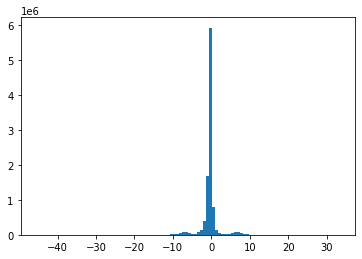

In [7]:
from sklearn.preprocessing import QuantileTransformer
data_transformed = []
for column in data:
    qt = QuantileTransformer(output_distribution='normal')
    data_transformed.append(np.array(qt.fit_transform(pd.DataFrame(data[column]))).reshape(10000000))
data_transformed = np.array(data_transformed)
data_transformed = data_transformed.T
# Please use the sklearn.preprocessing.QuantileTransformer to transform each feature
# into a Gaussian
plt.hist(data.values[:, 0], bins=HIST_BINS);

Результат должен выглядеть как-то так:
![image.png](https://github.com/yandexdataschool/mlhep2019/raw/master/notebooks/day-6/gauss.png)

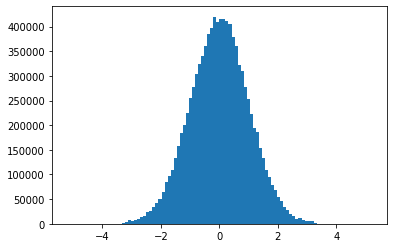

In [8]:
plt.hist(data_transformed[:, 0], bins=HIST_BINS);

In [0]:
train, test = train_test_split(data_transformed, test_size=0.1)
LATENT_DIM = 64 # Размерность "шума"


Здесь нашим генератором и дискриминатором может быть любая полносвязная сеть.

По желанию можно использовать шедулер :)

In [0]:
from torch.optim.lr_scheduler import StepLR
gen = nn.Sequential(
        nn.Linear(LATENT_DIM + len(X_COLUMNS), 128),
        nn.LeakyReLU(),
        nn.Linear(128, 64),
        nn.LeakyReLU(),
        nn.Linear(64, 32),
        nn.LeakyReLU(),
        nn.Linear(32, len(Y_COLUMNS)),
    ).to(device)
gen_opt = torch.optim.RMSprop(gen.parameters(), lr=1e-2)
gen_scheduler = StepLR(gen_opt, 800, gamma=0.95)

assert gen[0].in_features == LATENT_DIM + len(X_COLUMNS)
assert gen[-1].out_features == len(Y_COLUMNS)

In [0]:
disc = nn.Sequential(
        nn.Linear(data.shape[1], 128),
        nn.LeakyReLU(),
        nn.Linear(128, 64),
        nn.LeakyReLU(),
        nn.Linear(64, 32),
        nn.LeakyReLU(),
        nn.Linear(32, 1)
    ).to(device)
disc_opt = torch.optim.RMSprop(disc.parameters(), lr=1e-2)
disc_scheduler = disc_scheduler = StepLR(disc_opt, 800, gamma=0.95)


assert disc[0].in_features == data.shape[1]
assert disc[-1].out_features == 1

In [0]:
TRAIN_BATCH_SIZE = 1024

def sample_real_data(batch_size):
    """
    Inifintly repeats and shuffles the train dataset, outputs the
    result in delicious batches.
    """
    while True:
        dataloader = torch.utils.data.DataLoader(train,
                                                 batch_size=batch_size,
                                                 shuffle=True, drop_last=True)
        for batch in dataloader:
            yield batch
            
infinite_data = sample_real_data(TRAIN_BATCH_SIZE)


In [0]:
# Эта функция семплит данные из вашего генератора
# Принимает на вход x (condition) 
# Возвращает concat(gen_y, x)

def sample_gen_data(x):
    size = x.shape[0]
    noise = torch.randn(size, LATENT_DIM, device=device)
    gen_input = torch.cat([noise, x], dim=1)
    return torch.cat([gen(gen_input), x], dim=1)


In [0]:
test_sample = sample_gen_data(torch.from_numpy(train[:3, len(Y_COLUMNS):]).to(device))
assert test_sample.shape == (3, data.shape[1])

In [0]:
# https://github.com/caogang/wgan-gp/blob/master/gan_mnist.py

def calc_gradient_penalty_classic(critic:torch.nn.Module,
                                  real_data:torch.Tensor,
                                  fake_data:torch.Tensor):
    """
    Computes Gradient Penalty in random interpolates, in its classic form:
    (|∇(D(x)|^2 - 1)^2, x is interpolated between a real and a generated sample
    Args:
      critic: a torch model which gradient needs to be penalised
      real_data[batch_size, n_features]: a sample of real data
      fake_data[batch_size, n_features]: a sample of fake data
    Returns:
      torch.Tensor, scalar, gradient penalty evalute
    """
    assert real_data.shape == fake_data.shape
    alpha = torch.rand(real_data.shape[0], 1)
    alpha = alpha.expand(real_data.size()).to(device)

    interpolates = (alpha * real_data + ((1 - alpha) * fake_data)).to(device)
    interpolates = torch.autograd.Variable(interpolates, requires_grad=True)

    disc_interpolates = critic(interpolates)

    gradients = torch.autograd.grad(
        outputs=disc_interpolates, inputs=interpolates,
        grad_outputs=torch.ones(disc_interpolates.size(), device=device),
        create_graph=True, retain_graph=True, only_inputs=True)[0]

    gradient_penalty = ((gradients.norm(2, dim=1) - 1) ** 2).mean()
    return gradient_penalty

In [0]:
LAMBDA = 1. # for gradient-penalty
def train_disc(gan_type):
    """
    Trains the discriminator for one step. Please note
    this is not a pure function, it captutes the majority of variables
    from the context.
    """
    real_data = next(infinite_data).to(device)
    x_gen = next(infinite_data)[:, len(Y_COLUMNS):].to(device)
    gen_data = sample_gen_data(x_gen)
    # Загуглил функции потерь для разных ганов и написал
    if gan_type == "JS":
        disc_loss = torch.log(torch.mean(-disc(real_data))) - torch.log(torch.mean((-disc(gen_data) + 1)))
    elif gan_type == "WGAN":
        disc_loss = torch.mean(disc(gen_data)) - torch.mean(disc(real_data))
    elif gan_type == "LSGAN":
        disc_loss = torch.mean(disc(gen_data) ** 2) + torch.mean((1 - disc(real_data)) ** 2)
    elif gan_type == "WGAN-GP":
        disc_loss = torch.mean(disc(gen_data)) - torch.mean(disc(real_data)) + LAMBDA * calc_gradient_penalty_classic(disc, real_data, gen_data)
    else:
        raise ValueError("Unknown GAN type. Valid ones are: JS, WGAN-GP, WGAN, LSGAN")
    
    disc_opt.zero_grad()
    disc_loss.backward()
    disc_opt.step()
    return disc_loss

In [0]:
def train_gen(gan_type):
    gen_data = sample_gen_data(next(infinite_data)[:, len(Y_COLUMNS):].to(device))
    # Для генераторов тоже выписываем функции потерь
    if gan_type == "JS":
        gen_loss = torch.mean((1 - disc(gen_data)).log())
    elif gan_type == "WGAN":
        gen_loss = torch.mean(-disc(gen_data))
    elif gan_type == "LSGAN":
        gen_loss = torch.mean((1 - disc(gen_data)) ** 2)
    elif gan_type == "WGAN-GP":
        gen_loss = torch.mean(-disc(gen_data))
    else:
        raise ValueError("Unknown GAN type. Valid ones are: JS, WGAN-GP, WGAN, LSGAN")
        
    gen_opt.zero_grad()
    gen_loss.backward()
    gen_opt.step()
    return gen_loss

In [19]:
experiment = Experiment(api_key="K5gK6ije55t8lsttg7cesT5hy", project_name="gan", workspace="gosha6037")

COMET INFO: Experiment is live on comet.ml https://www.comet.ml/gosha6037/gan/5632a21e110f42bea367953b48901e8b



In [0]:
DISCRIMINATOR_ITERATIONS_PER_GENEREATOR = 5
VALIDATION_INTERVAL = 100
DATA_HIST_RANGE=[-5, 5]

In [0]:
data_linspace_np = np.linspace(0, 10, num=256, dtype=np.float32)
data_linspace_torch = torch.from_numpy(data_linspace_np)[:, None].to(device)
validation_data = torch.from_numpy(test).to(device)
validation_data_np = test
validation_x = validation_data[:, len(Y_COLUMNS):]

In [0]:
def going_model(model, steps=100000):
    for i in range(steps):
        gen_scheduler.step()
        disc_scheduler.step()
        for _ in range(DISCRIMINATOR_ITERATIONS_PER_GENEREATOR):
            disc_loss_this_iter = train_disc(model)
        
        gen_loss_this_iter = train_gen(model)
        experiment.log_metric('loss/discriminator', disc_loss_this_iter.item(), step=i)
        experiment.log_metric('loss/generator', gen_loss_this_iter.item(), step=i)

        if i % VALIDATION_INTERVAL == 0:
            clear_output(True)
            print('Processing...', i, 'out of', steps, 'completed')     
            validation_generated = sample_gen_data(validation_x)
            validation_generated_np = validation_generated.data.cpu().numpy()
            out = validation_generated_np
            
            fig, axes_list = plt.subplots(ncols=5, figsize=[6*len(Y_COLUMNS), 6])
            for index, ax in enumerate(axes_list):
                ax.hist(validation_generated_np[:, index], range=DATA_HIST_RANGE,
                    alpha=0.5, density=True, label='Generated', bins=HIST_BINS)
                ax.hist(validation_data_np[:, index], range=DATA_HIST_RANGE,
                    alpha=0.5, density=True, label='Real', bins=HIST_BINS)
                ax.set_xlabel(data.columns[index])
                ks_result = ks_2samp(validation_generated_np[:, index],
                                        validation_data_np[:, index])
                ax.set_title("KS stat = {:.4f}; p-value = {:.4E}".format(*tuple(ks_result)))
            fig.suptitle("Iteration {}".format(i))
            plt.show()

Ниже у нас JS GAN, как видно он не оч хорошо справился с задачей, но все же было дано не так много эпох, при устремлении их к миллиону результат становиться выше. Как видно результат далеко не всегда отцентрирован.

Processing... 9900 out of 10000 completed


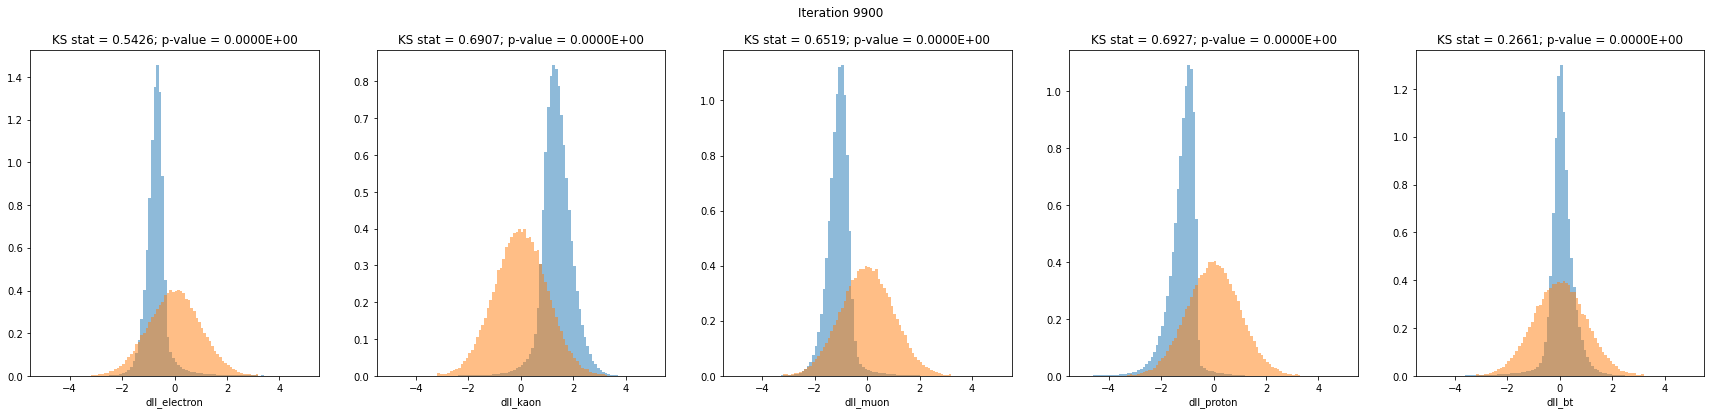

In [23]:
going_model('JS', steps=10000)

Как можно видеть нижке, качество у WGAN значительно лучше, и даже за такое маленько число операций почти покрывает. Кстати когда устремлял число операций к ляму перекрытие было почти полное.
Собственно на 10000 тут получился лучший результат.

Processing... 9900 out of 10000 completed


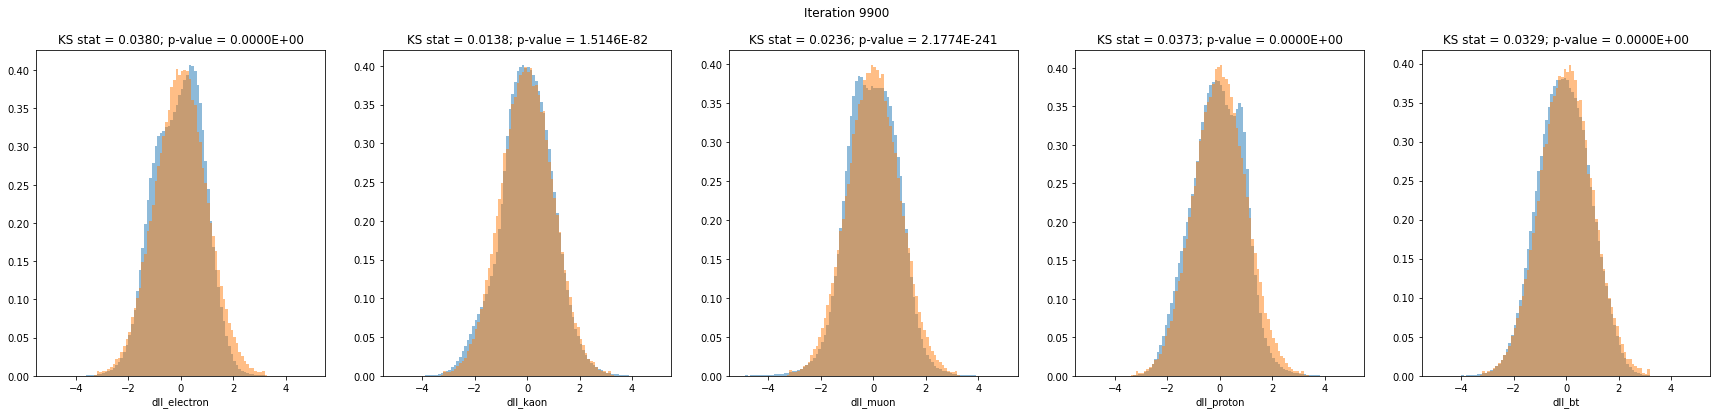

In [25]:
going_model('WGAN', steps=10000)

LSGAN вообще получился самый точный по метрике ROC AUC для классификатора, но сейчас при обучении на 10000 не такой уж и васокий результат.

Processing... 9900 out of 10000 completed


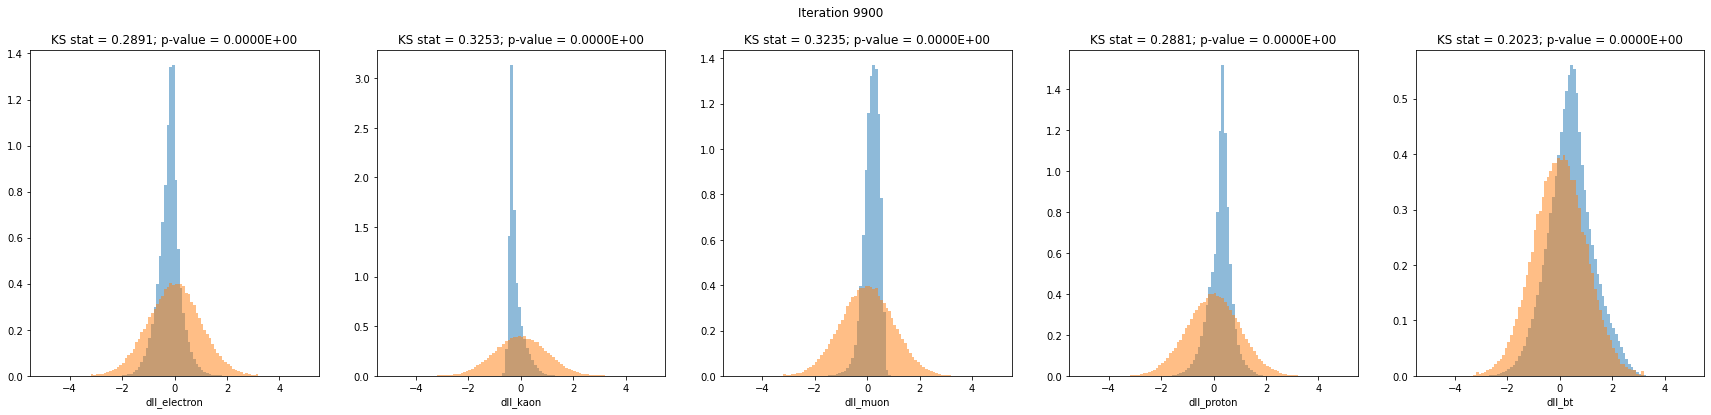

In [27]:
going_model('LSGAN', steps=10000)

WGAN-GP 5700 лучше чем WGAN по метрике, но хуже LSGAN при обучении на 100000. Но на 10000 как видно результаты не сильно лучше LSGAN, Обучил чуть меньше так как хотел сдать пораньше.

Processing... 5700 out of 10000 completed


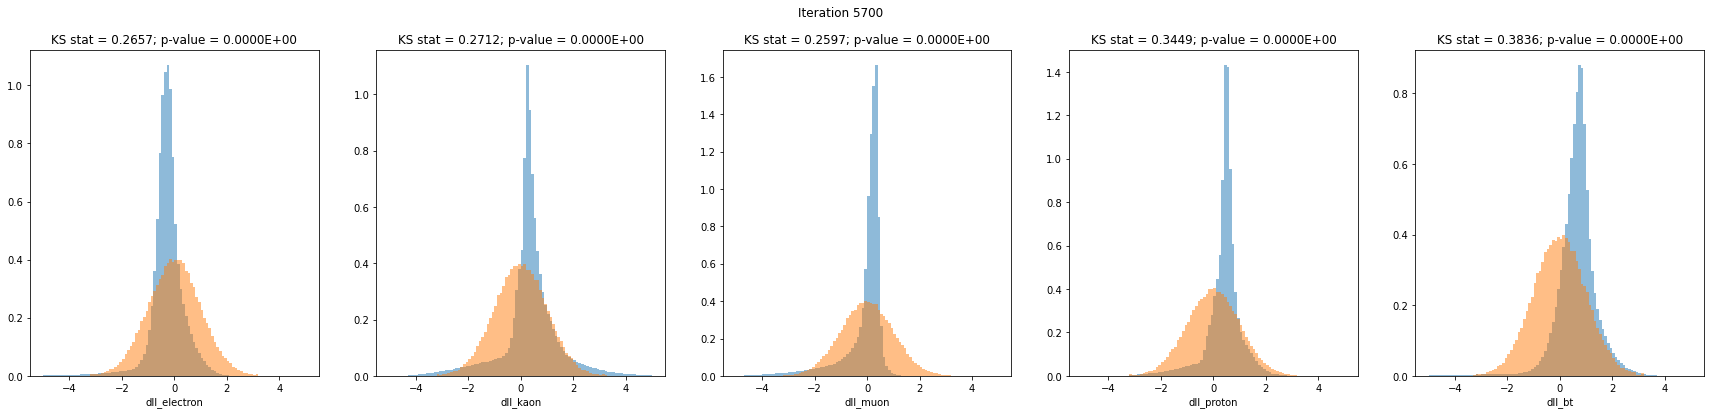

KeyboardInterrupt: ignored

In [29]:
going_model('WGAN-GP', steps=10000)

Решил для классификации использоавать LogisticRegression так как за качеством я не гонюсь, а это простой и легкий алгоритм

In [31]:
from xgboost import XGBClassifier
from sklearn.metrics import roc_auc_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
size = validation_x.shape[0]
true = np.array(train[:size])
false = np.array(sample_gen_data(validation_x).detach())
X = np.concatenate([true, false])
y = []
for _ in range(size):
    y.append(0)
for _ in range(size):
    y.append(1)
y = np.array(y).reshape(-1)
X_train, X_test = train_test_split(X)
y_train, y_test = train_test_split(y)
lr = LogisticRegression()
lr.fit(X_train, y_train)
roc_auc_score(y_tst, lr.predict_proba(X_test)[:,1])

0.64156735687


### Метрика с классификатором, 2 балла

Одним из возможных способов подсчета качества вашего гана является качество классификатора обученного на разделение реальных и сгенерированных данных.

1. Возьмите модель, например catboost, xgboost или lightgbm
2. Сгененируйте достаточно большие выборки из реальных и сгенерированных данных (для каждой построенной вами модели)
3. Обучите модель на бинарную классификацию
4. Посчитайте ROC AUC модели, чем ближе к 0.5, тем лучше

### Обьяснения, 0.5 балла

1. Напишите, почему для одних ганов метрика выше чем для других.
2. Напишите как можно было бы улучшить те ганы которые у вас есть. 
3. Напишите, какие бы еще модели тут можно было бы попробовать

1) Вообще так грубо сравнивать не совсем корректно, тк некоторые ганы требуют тщательную настройку парметров, а некоторые так заводяятся. Но в целом разные ганы оптимизируют разное расстояние меж плотностями распределений и по разному ведут на крайних точках, потому каждый из них имеет какие-то сильные и слабые стороны.

2) Можно импользовать не жесткие метки, вместо 0 и 1 брать 0.1 и 0.9.
Можно хранить дополнительно примеры на готорых дискреминатор плохой ответ давал (из сгенерированных) и иногда ему закидывать.
Можно использовать нормирование, по батчу или группе например, или минибатч для дискреминатора. Можно добавить регуляризацию, увеличить число слоев или архитектуру сетей, тщательно подобрать параметры.

3) Можно еще попробовать и сравнить: BEGAN, DRGAN MM GAN, NS GAN также можно сравнить с VAE